In [1]:
import torch
import torch.nn as nn
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from ipywidgets import interact

from src.data.box import GravityHoleBall
from src.data.generate import generate_gravity_hole_ball_images

from src.utils.utils import add_spatial_encoding
from src.utils.node import  BatchGetterMultiImages, train_convnode_with_batch
from src.utils.viz import  display_convnode_trajectory

from src.models.convnode import ConvNodeWithBatch#, LatentRegularizerLoss


In [13]:
MARGIN_MIN = 5
MIN_INIT_VELOCITY = 200.
WIDTH, HEIGHT = 28, 28
RADIUS = 3

infos = {
    "MARGIN_MIN":MARGIN_MIN,
    "MIN_INIT_VELOCITY":MIN_INIT_VELOCITY,
    "WIDTH":WIDTH,
    "HEIGHT":HEIGHT,
    "RADIUS":RADIUS
}

x = WIDTH/4.
y = HEIGHT/4.
vx = 0.
vy = 0.

box = GravityHoleBall(x, y, vx, vy, (WIDTH, HEIGHT),RADIUS)


Num_pos_velocity = 1
N = 300
N_frames = 300 + Num_pos_velocity
dt = 1./N_frames

times = np.arange(0, N_frames*dt, dt)

# encoded_trajectory = generate_gravity_hole_ball_positions(box, N=N, N_frames=N_frames, dt=dt)[:,:,:]
# print(encoded_trajectory.shape)
print("-"*50)
print("Generating images...")
images = generate_gravity_hole_ball_images(box, N=N, N_frames=N_frames, dt=dt, infos=infos).reshape(-1, 1, HEIGHT, WIDTH)
print(images.shape)
# dataset = [(image, 0) for image in dataset]
# dataset = add_spatial_encoding(dataset)
# print(len(dataset), len(dataset[0]), dataset[0][0].shape)
images = torch.from_numpy(add_spatial_encoding(images)).float().reshape(N, -1, 3, HEIGHT, WIDTH)
print(images.shape)


--------------------------------------------------
Generating images...


100%|██████████| 300/300 [00:15<00:00, 19.37it/s]


(90300, 1, 28, 28)
torch.Size([300, 301, 3, 28, 28])


In [14]:
print("-"*50)
print("Creating model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
size = 28
latent_dim = 32
in_channels = 3
ode_data_dim = latent_dim
ode_hidden_dim = 128
augment_dim=0
time_dependent=False
ode_non_linearity='relu' 
conv_activation=nn.ReLU()
latent_activation=None
stack_size=1

conv_ode = ConvNodeWithBatch(device, size, latent_dim, in_channels,
    ode_hidden_dim, ode_data_dim, augment_dim=augment_dim, time_dependent=time_dependent,
    ode_non_linearity=ode_non_linearity, ode_linear_layer=False, conv_activation=conv_activation,
    latent_activation=latent_activation, stack_size=stack_size)

# pathConvODE = "models/AE_ODE/ConvODE/conv_ode_1_ball_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}_with_lambda_decay.pt".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
# print(conv_ode.load_state_dict(torch.load(pathConvODE)))

--------------------------------------------------
Creating model...
--------------------------------------------------
Creating ConvAE...
Number of parameters in the encoder model: 146016
Number of parameters in the decoder model: 146147
--------------------------------------------------
Creating ANODENet...
Number of parameters in the model: 35168


In [15]:
print("-"*50)
print("Creating tools to train...")
batch_size = 32
batch_time = 100
n_stack = 1
total_length = N_frames - Num_pos_velocity
getter = BatchGetterMultiImages(batch_time, batch_size, n_stack, total_length, dt, images.to(device), frac_train=1.)

--------------------------------------------------
Creating tools to train...


In [32]:
class LatentRegularizerLoss(nn.Module):
    def __init__(self, device, reg_lambda, step_decay=1, decay_rate=0.9):
        super(LatentRegularizerLoss, self).__init__()
        self.device = device
        self.reg_lambda = reg_lambda
        self.image_loss = nn.MSELoss()
        self.step_decay = step_decay
        self.decay_rate = decay_rate
        self._step = 0

    def forward(self, latent_z, pred_images, true_images):
        # latent_z: [batch, latent_dim]
        # pred_images: [batch, n_stack, in_channels, height, width]
        # true_images: [batch, n_stack, in_channels, height, width]
        loss_img = self.image_loss(pred_images, true_images)
        loss_reg = torch.linalg.norm(latent_z, ord=2, dim=-1).mean(dim=-1).mean(dim=-1)
        # print("loss_img: ", loss_img)
        # print("loss_reg: ", loss_reg)
        return loss_img + self.reg_lambda * loss_reg
    

    def step(self):
        self._step +=1
        if self._step % self.step_decay == 0:
            self.reg_lambda *= self.decay_rate
            

    def forward_print(self, latent_z, pred_images, true_images):
        # latent_z: [batch, latent_dim]
        # pred_images: [batch, n_stack, in_channels, height, width]
        # true_images: [batch, n_stack, in_channels, height, width]
        loss_img = self.image_loss(pred_images, true_images)
        loss_reg = torch.linalg.norm(latent_z, ord=2, dim=-1).mean(dim=-1).mean(dim=-1)
        print("-"*30, "Loss prints", "-"*30)
        print("loss_img: ", loss_img)
        print("loss_reg: ", self.reg_lambda * loss_reg)
        print("reg_lambda: ",self.reg_lambda)
        print("-"*73)
        return None

reg_lambda = 0.0005
optimizer = torch.optim.Adam(conv_ode.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.9)
loss_fn = LatentRegularizerLoss(device, reg_lambda, step_decay=3000, decay_rate=0.8)

The graphs at epoch 0


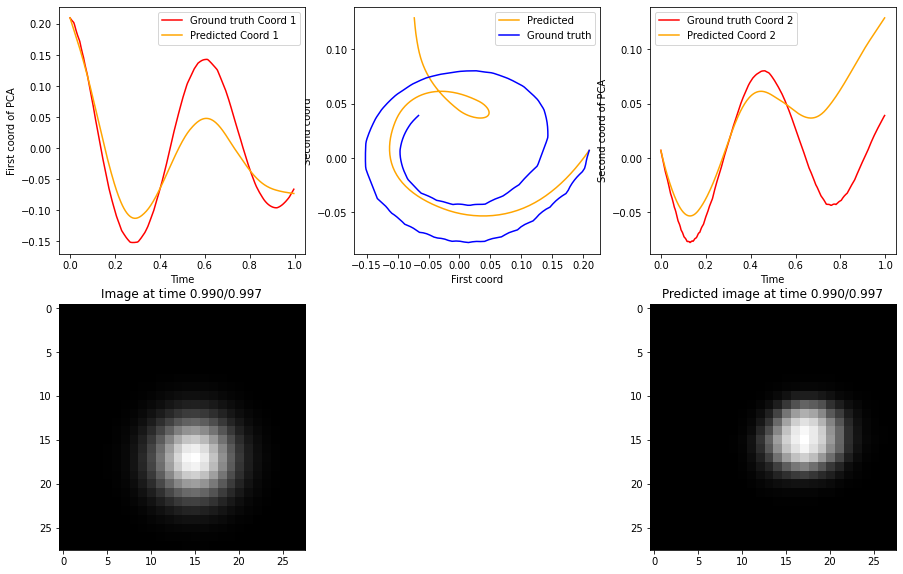

In [29]:
root = None #"images/AE_ODE/Gravity/MultiTrajectories/Together/"
name = None # "conv_ode_1_ball_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
display_fn = lambda i, model, out_display, getter, final_time, dt: display_convnode_trajectory(i, model, out_display, getter, final_time, dt, root=root, name=name)
display_fn(0, conv_ode, latent_dim, getter, N_frames - Num_pos_velocity, dt)

--------------------------------------------------
Training...


 10%|▉         | 999/10000 [01:38<15:28,  9.70it/s, Loss: 0.00185175]

The graphs at epoch 1000


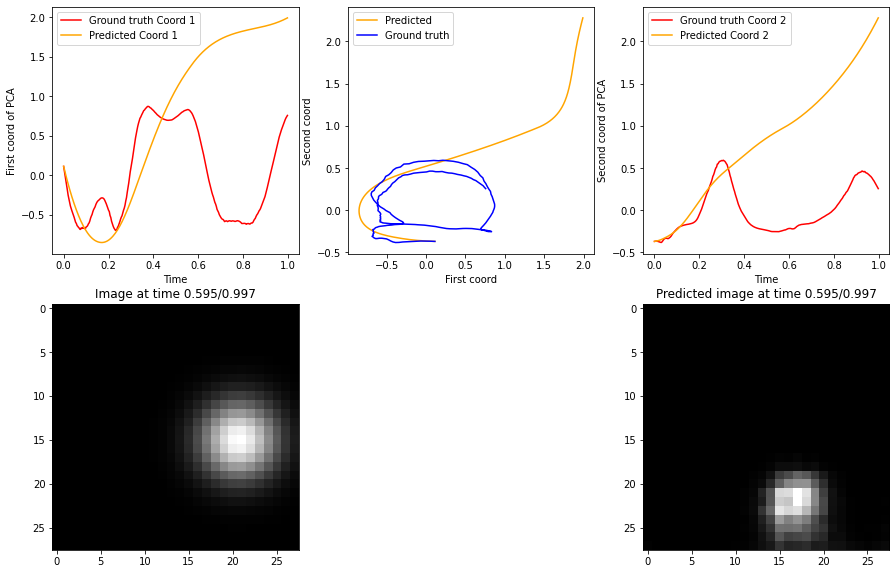

Display loss: 0.01134162:  10%|█         | 1000/10000 [01:39<42:20,  3.54it/s, Loss: 0.00196524]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)
loss_reg:  tensor(0.0003, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0005
-------------------------------------------------------------------------


Display loss: 0.01134162:  20%|█▉        | 1999/10000 [03:23<13:27,  9.90it/s, Loss: 0.00157171]

The graphs at epoch 2000


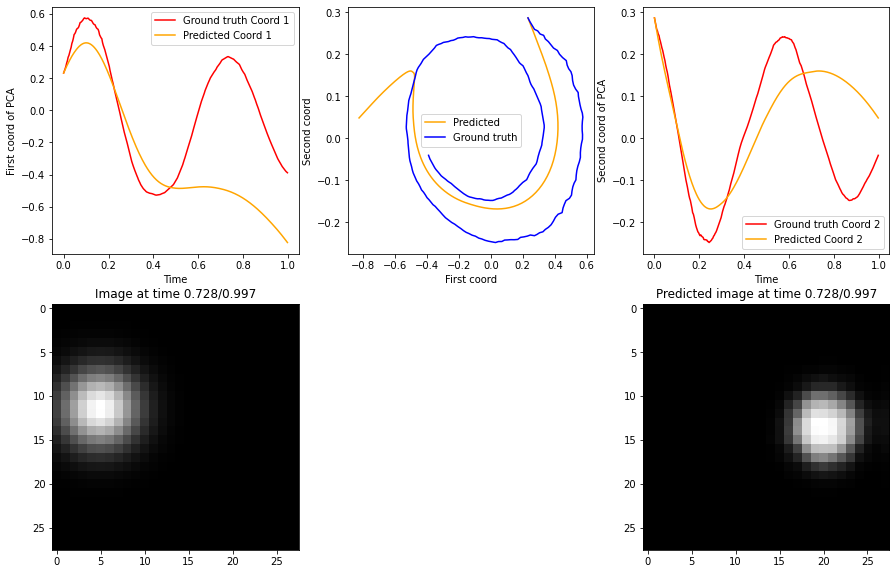

Display loss: 0.00141499:  20%|██        | 2001/10000 [03:23<29:33,  4.51it/s, Loss: 0.00082179]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)
loss_reg:  tensor(0.0002, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0005
-------------------------------------------------------------------------


Display loss: 0.00141499:  30%|██▉       | 2999/10000 [05:07<12:01,  9.70it/s, Loss: 0.00064952]

The graphs at epoch 3000


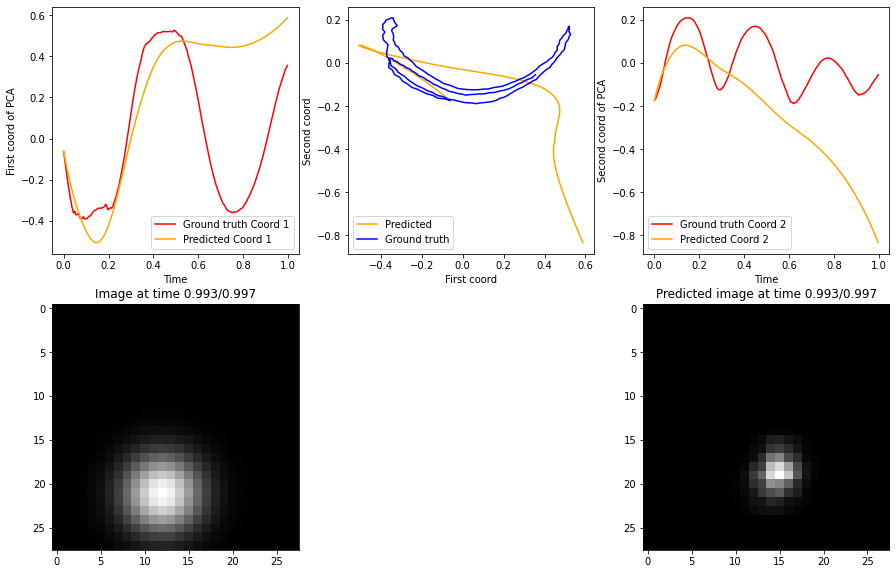

Display loss: 0.00077722:  30%|███       | 3001/10000 [05:08<25:33,  4.56it/s, Loss: 0.00064885]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)
loss_reg:  tensor(0.0001, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0004
-------------------------------------------------------------------------


Display loss: 0.00077722:  40%|███▉      | 3999/10000 [06:53<10:30,  9.51it/s, Loss: 0.00097598]

The graphs at epoch 4000


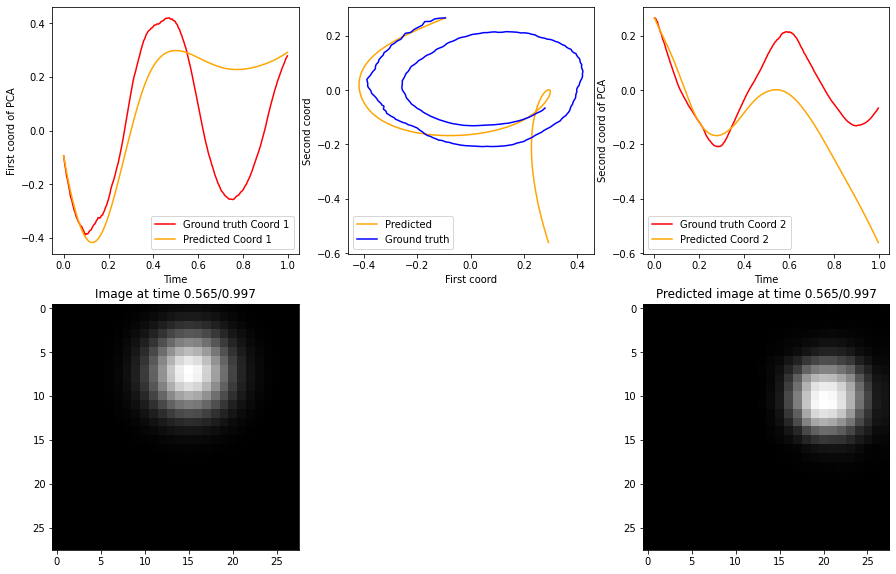

Display loss: 0.00059098:  40%|████      | 4001/10000 [06:53<21:44,  4.60it/s, Loss: 0.00038416]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)
loss_reg:  tensor(0.0001, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0004
-------------------------------------------------------------------------


Display loss: 0.00059098:  50%|████▉     | 4999/10000 [08:37<08:41,  9.59it/s, Loss: 0.00064192]

The graphs at epoch 5000


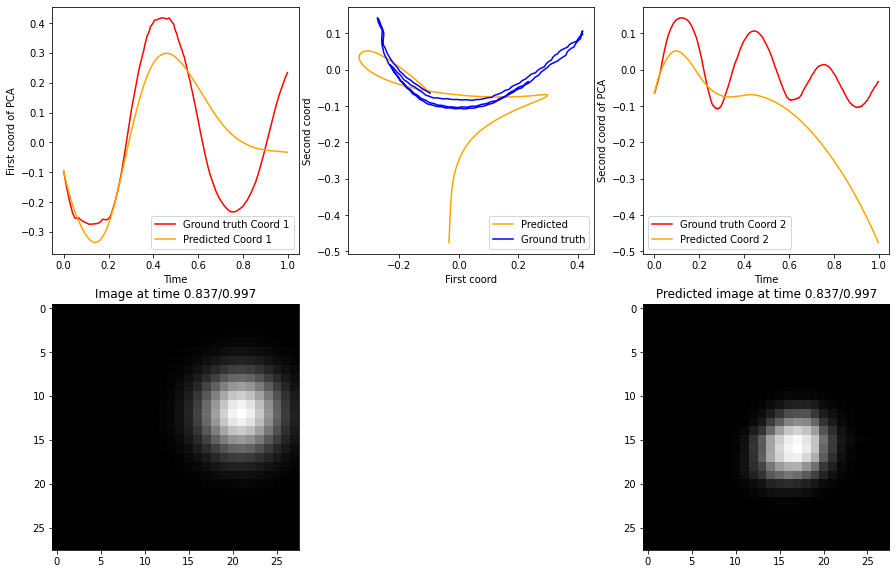

Display loss: 0.00048041:  50%|█████     | 5001/10000 [08:38<18:31,  4.50it/s, Loss: 0.00072023]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)
loss_reg:  tensor(0.0001, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0004
-------------------------------------------------------------------------


Display loss: 0.00048041:  60%|█████▉    | 5999/10000 [10:22<06:43,  9.92it/s, Loss: 0.00022640]

The graphs at epoch 6000


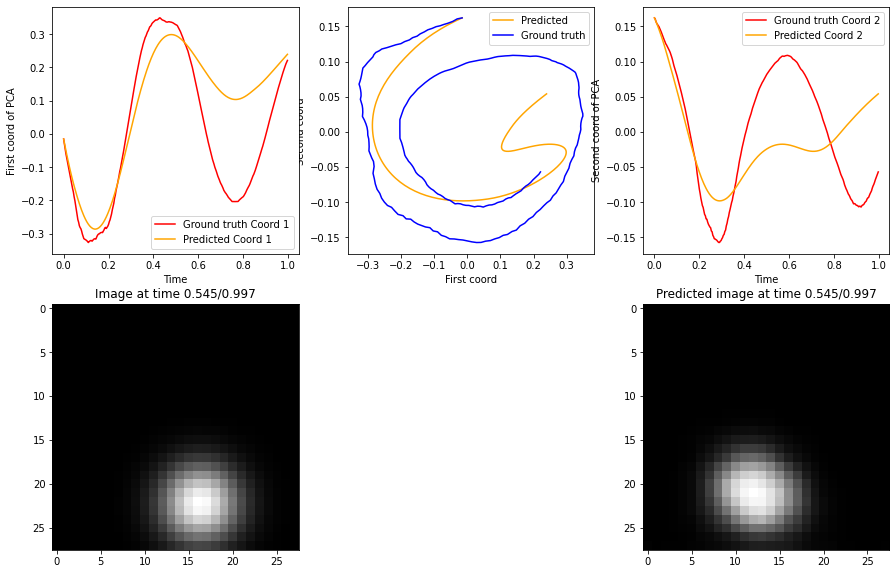

Display loss: 0.00043284:  60%|██████    | 6001/10000 [10:23<16:13,  4.11it/s, Loss: 0.00038423]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)
loss_reg:  tensor(5.0097e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.00032
-------------------------------------------------------------------------


Display loss: 0.00043284:  70%|██████▉   | 6999/10000 [12:06<05:11,  9.62it/s, Loss: 0.00022252]

The graphs at epoch 7000


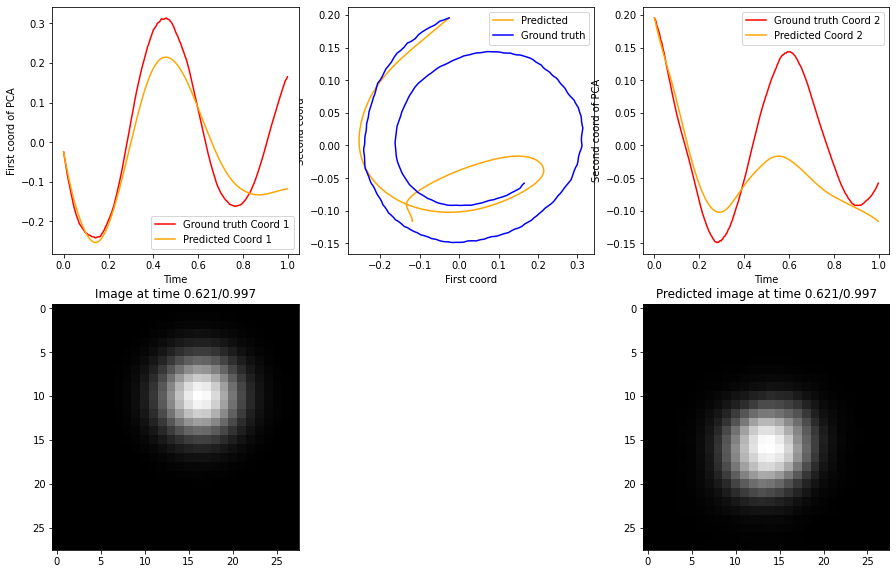

Display loss: 0.00034911:  70%|███████   | 7001/10000 [12:07<11:05,  4.51it/s, Loss: 0.00026453]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)
loss_reg:  tensor(5.5556e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.00032
-------------------------------------------------------------------------


Display loss: 0.00034911:  80%|███████▉  | 7999/10000 [13:51<03:24,  9.76it/s, Loss: 0.00040407]

The graphs at epoch 8000


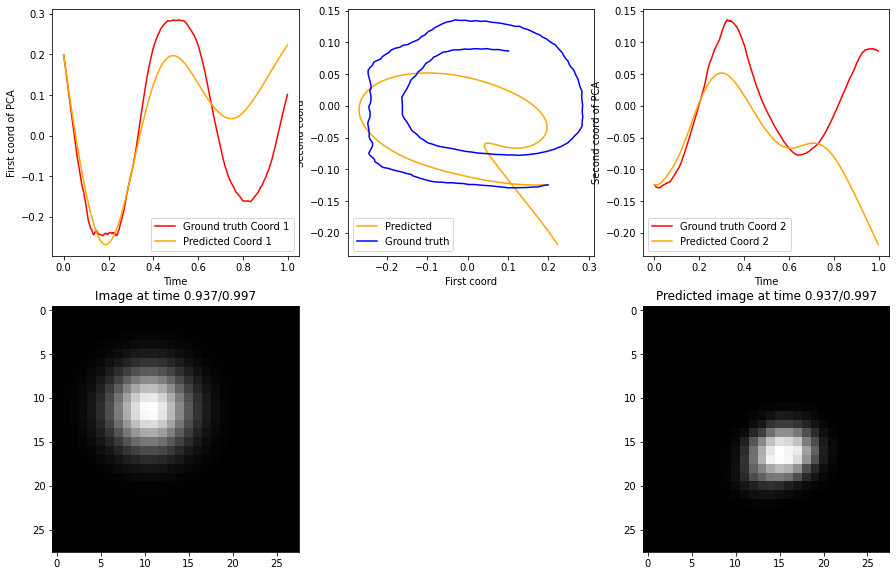

Display loss: 0.00034836:  80%|████████  | 8000/10000 [13:51<09:00,  3.70it/s, Loss: 0.00026260]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)
loss_reg:  tensor(7.4866e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.00032
-------------------------------------------------------------------------


Display loss: 0.00034836:  90%|████████▉ | 8999/10000 [15:35<01:42,  9.77it/s, Loss: 0.00055463]

The graphs at epoch 9000


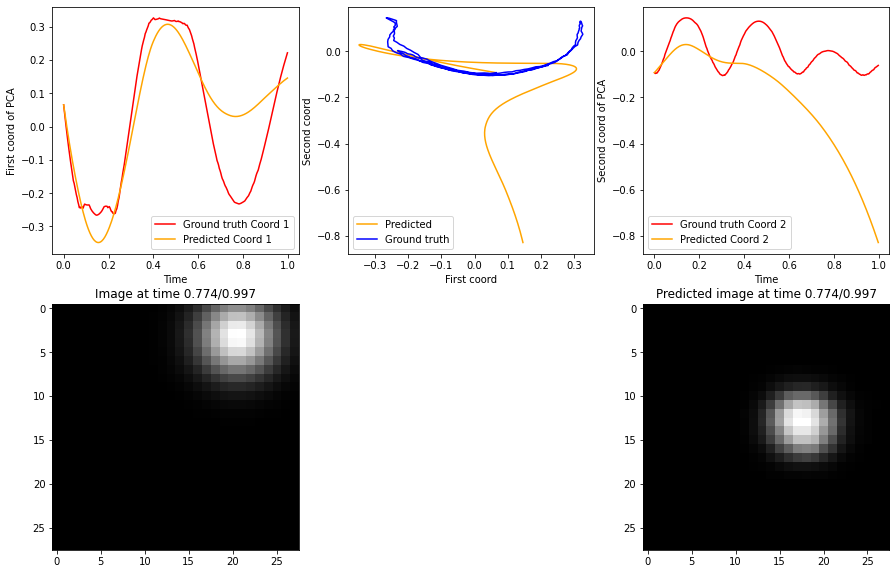

Display loss: 0.00029062:  90%|█████████ | 9001/10000 [15:35<03:36,  4.62it/s, Loss: 0.00043161]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)
loss_reg:  tensor(6.5813e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.00025600000000000004
-------------------------------------------------------------------------


Display loss: 0.00029062: 100%|█████████▉| 9999/10000 [17:19<00:00,  9.82it/s, Loss: 0.00022248]

The graphs at epoch 10000


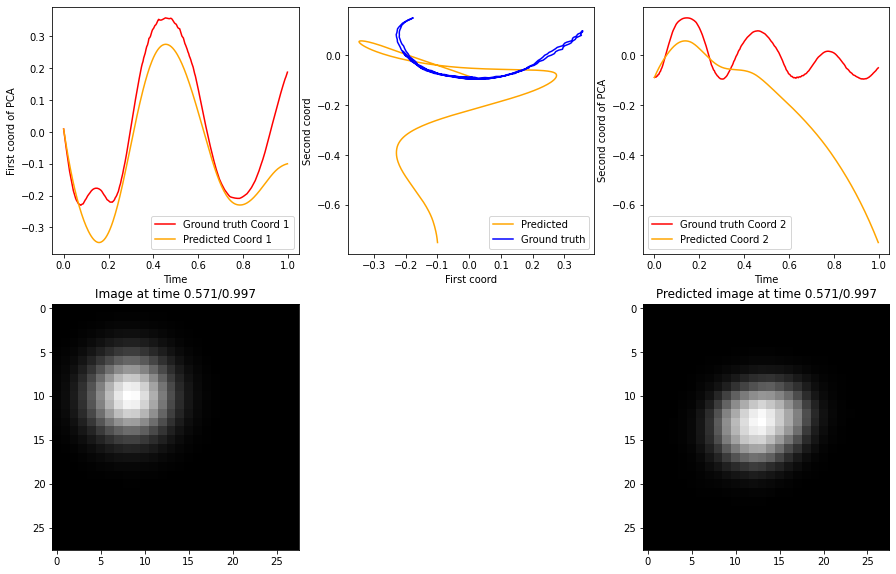

Display loss: 0.00027592: 100%|██████████| 10000/10000 [17:19<00:00,  9.62it/s, Loss: 0.00022248]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)
loss_reg:  tensor(5.3729e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.00025600000000000004
-------------------------------------------------------------------------


In [18]:
print("-"*50)
print("Training...")
epochs = 10000
train_convnode_with_batch(conv_ode, optimizer, scheduler, epochs,
    getter, loss_fn=loss_fn, display=1000, display_results_fn=display_fn)

In [30]:
pathConvODE = "conv_ode_1_ball_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}_with_lambda_decay_together.pt".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
torch.save(conv_ode.state_dict(), pathConvODE)

--------------------------------------------------
Training...


 10%|▉         | 999/10000 [01:41<15:26,  9.71it/s, Loss: 0.00016675]

The graphs at epoch 1000


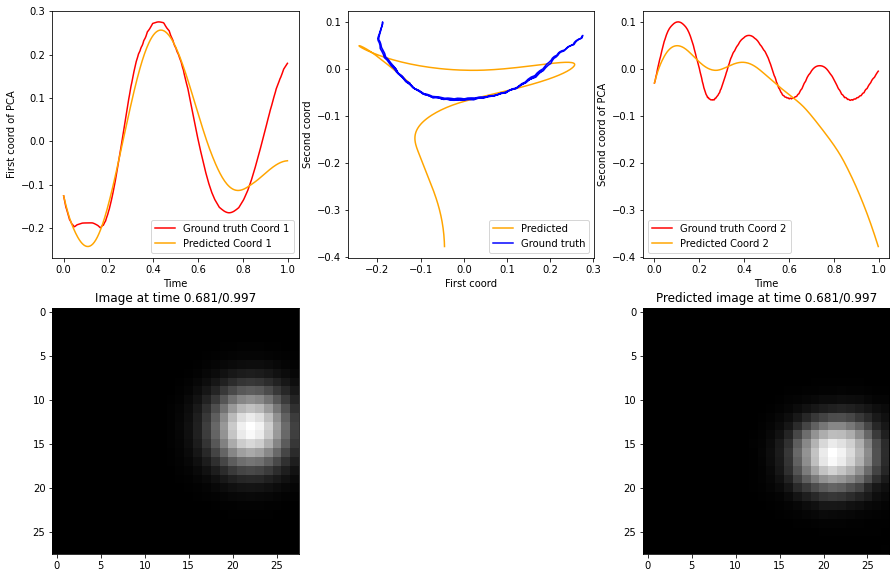

Display loss: 0.00029867:  10%|█         | 1001/10000 [01:42<32:43,  4.58it/s, Loss: 0.00031370]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)
loss_reg:  tensor(6.6204e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0005
-------------------------------------------------------------------------


Display loss: 0.00029867:  20%|█▉        | 1999/10000 [03:24<13:24,  9.94it/s, Loss: 0.00022206]

The graphs at epoch 2000


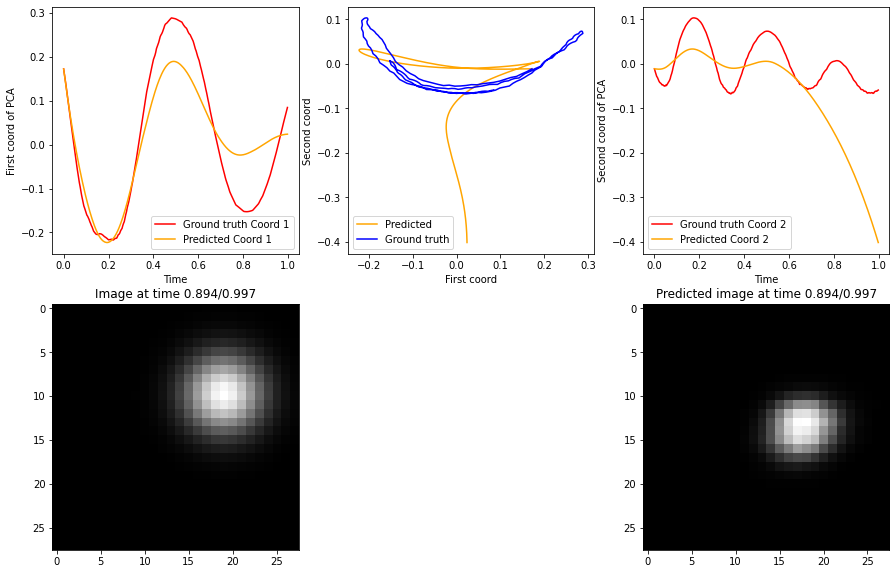

Display loss: 0.00028010:  20%|██        | 2001/10000 [03:25<25:40,  5.19it/s, Loss: 0.00027548]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)
loss_reg:  tensor(8.1989e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0005
-------------------------------------------------------------------------


Display loss: 0.00028010:  30%|██▉       | 2999/10000 [05:06<12:00,  9.71it/s, Loss: 0.00018862]

The graphs at epoch 3000


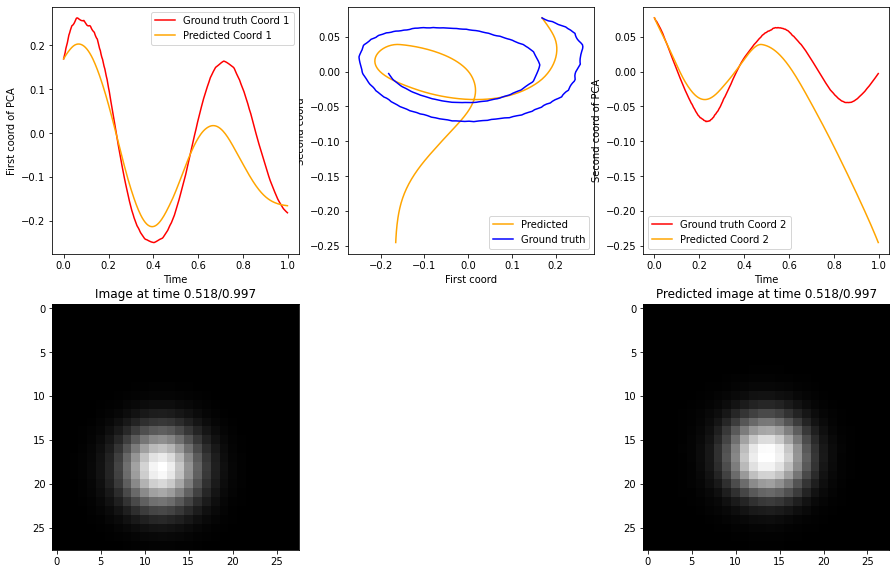

Display loss: 0.00024733:  30%|███       | 3002/10000 [05:07<21:48,  5.35it/s, Loss: 0.00025040]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)
loss_reg:  tensor(6.5818e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0004
-------------------------------------------------------------------------


Display loss: 0.00024733:  40%|███▉      | 3999/10000 [06:49<10:03,  9.95it/s, Loss: 0.00037703]

The graphs at epoch 4000


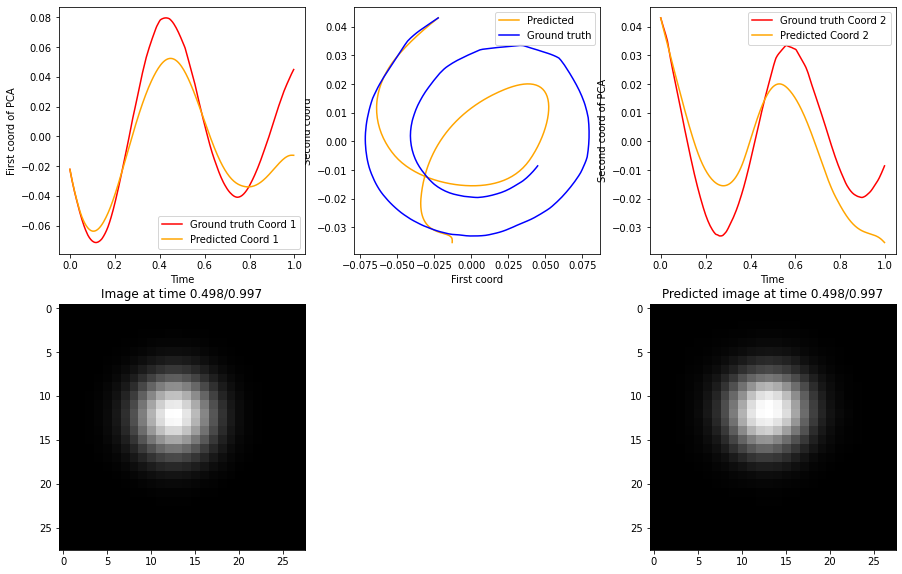

Display loss: 0.00023570:  40%|████      | 4002/10000 [06:50<19:42,  5.07it/s, Loss: 0.00024351]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)
loss_reg:  tensor(7.8293e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0004
-------------------------------------------------------------------------


Display loss: 0.00023570:  50%|████▉     | 4998/10000 [08:32<08:32,  9.77it/s, Loss: 0.00023451]

The graphs at epoch 5000


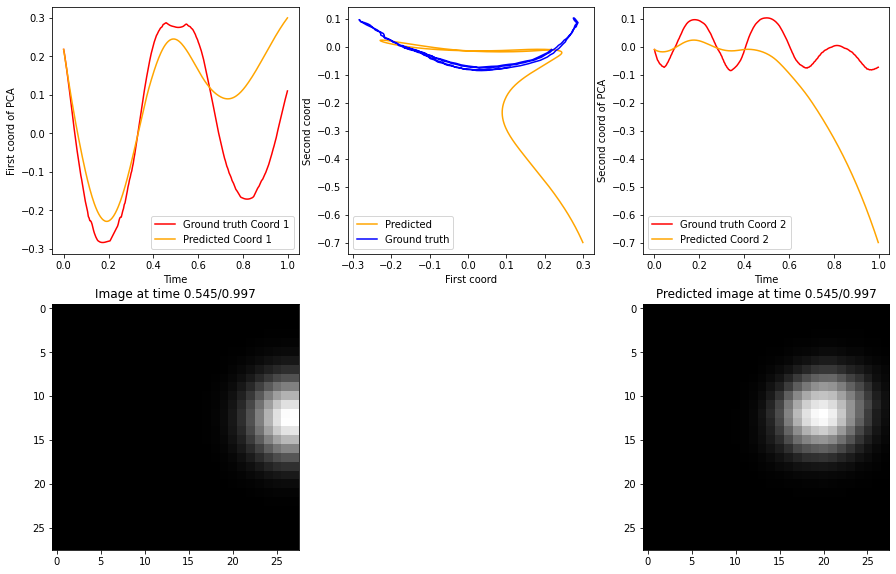

Display loss: 0.00021923:  50%|█████     | 5001/10000 [08:33<17:10,  4.85it/s, Loss: 0.00028966]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)
loss_reg:  tensor(6.2224e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.0004
-------------------------------------------------------------------------


Display loss: 0.00021923:  60%|█████▉    | 5998/10000 [10:15<06:49,  9.78it/s, Loss: 0.00017836]

The graphs at epoch 6000


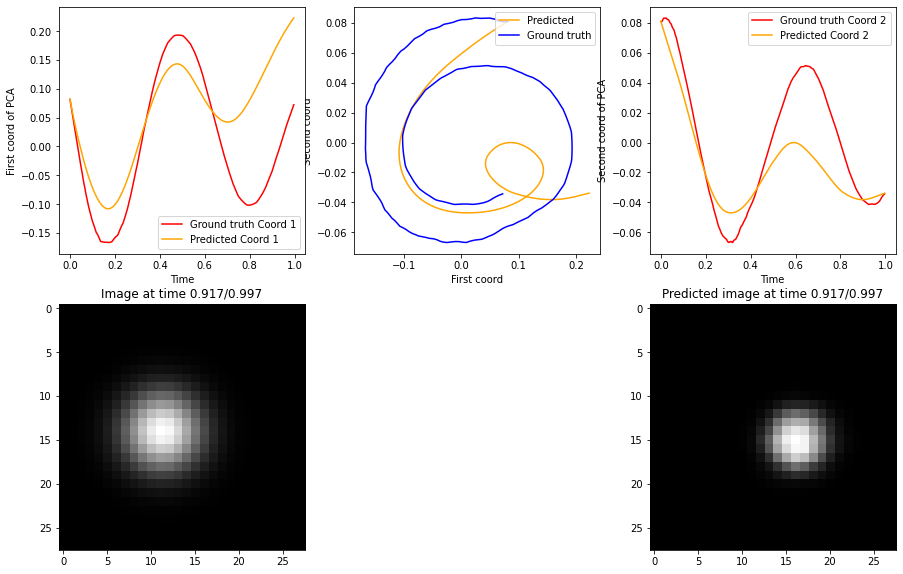

Display loss: 0.00021001:  60%|██████    | 6001/10000 [10:15<12:53,  5.17it/s, Loss: 0.00027191]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)
loss_reg:  tensor(5.0447e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.00032
-------------------------------------------------------------------------


Display loss: 0.00021001:  70%|██████▉   | 6999/10000 [11:58<05:07,  9.76it/s, Loss: 0.00022902]

The graphs at epoch 7000


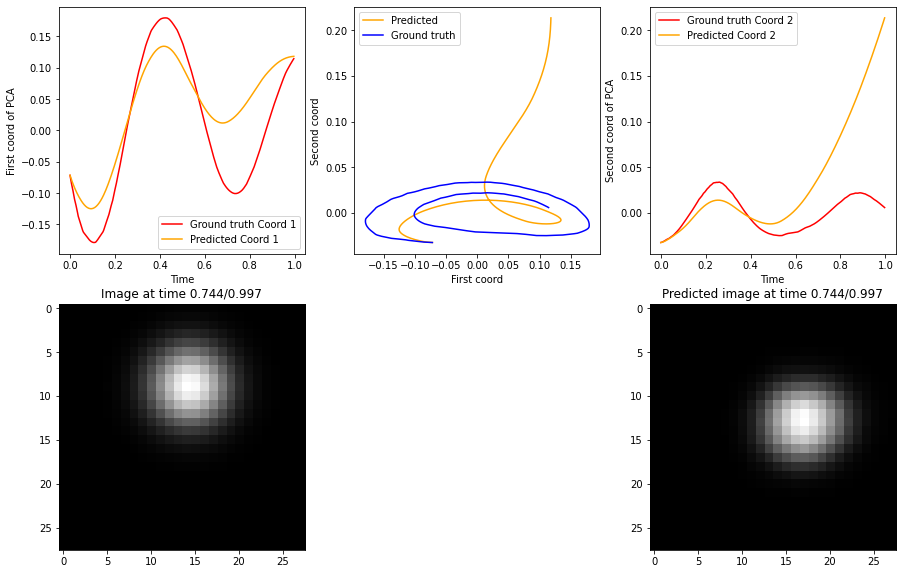

Display loss: 0.00018408:  70%|███████   | 7002/10000 [11:58<09:07,  5.48it/s, Loss: 0.00032018]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)
loss_reg:  tensor(5.3302e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.00032
-------------------------------------------------------------------------


Display loss: 0.00018408:  80%|███████▉  | 7999/10000 [13:41<03:25,  9.75it/s, Loss: 0.00014132]

The graphs at epoch 8000


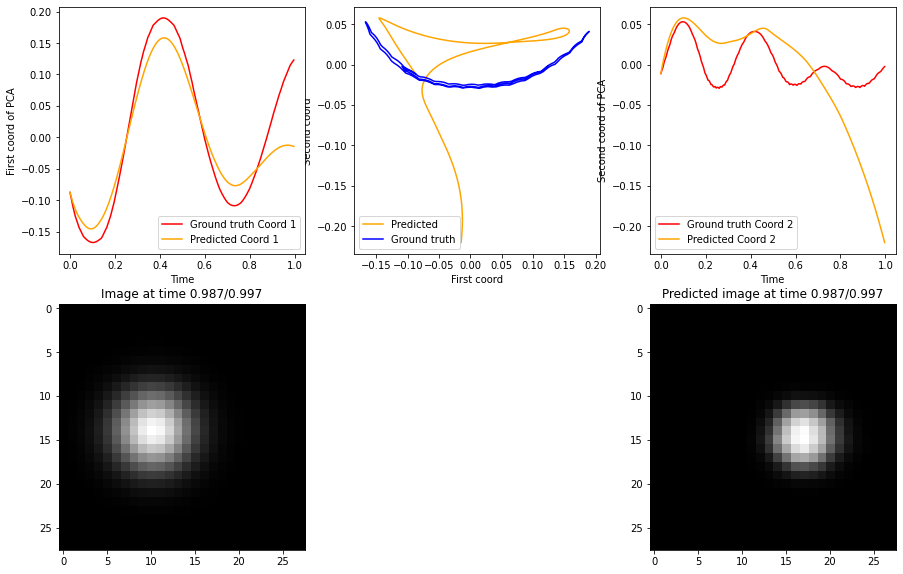

Display loss: 0.00019059:  80%|████████  | 8000/10000 [13:41<08:54,  3.74it/s, Loss: 0.00032275]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)
loss_reg:  tensor(4.0201e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.00032
-------------------------------------------------------------------------


Display loss: 0.00019059:  90%|████████▉ | 8998/10000 [15:24<01:43,  9.70it/s, Loss: 0.00010972]

The graphs at epoch 9000


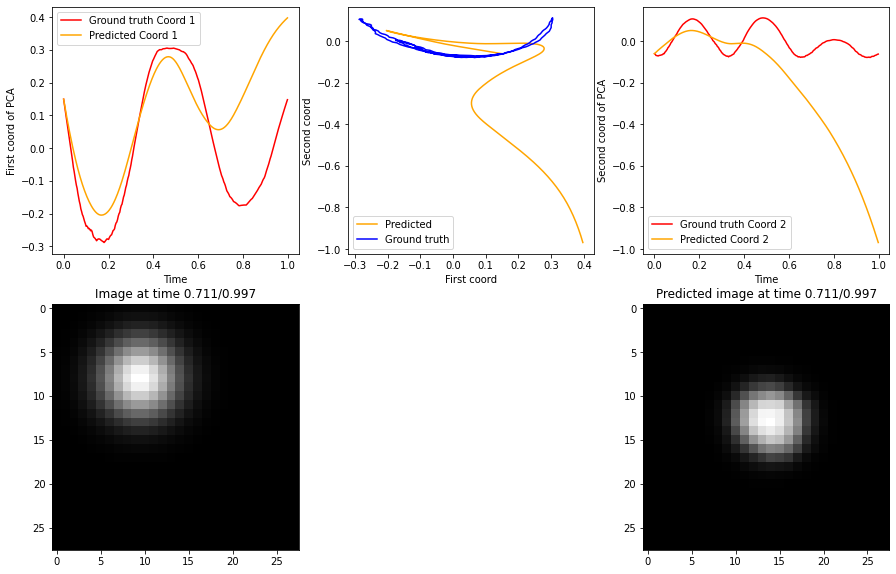

Display loss: 0.00017289:  90%|█████████ | 9001/10000 [15:25<03:38,  4.58it/s, Loss: 0.00022399]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(6.8775e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
loss_reg:  tensor(3.2759e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.00025600000000000004
-------------------------------------------------------------------------


Display loss: 0.00017289: 100%|█████████▉| 9998/10000 [17:06<00:00,  9.99it/s, Loss: 0.00026091]

The graphs at epoch 10000


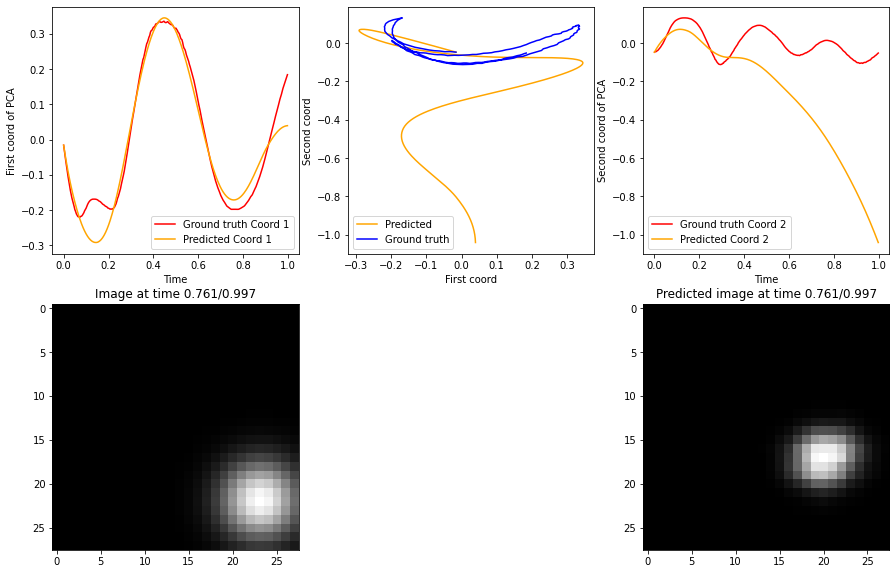

Display loss: 0.00016466: 100%|██████████| 10000/10000 [17:07<00:00,  9.73it/s, Loss: 0.00026091]

------------------------------ Loss prints ------------------------------
loss_img:  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)
loss_reg:  tensor(4.4782e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  0.00025600000000000004
-------------------------------------------------------------------------


In [33]:
print("-"*50)
print("Training...")
for param in conv_ode.encoder.parameters():
    param.requires_grad = False

epochs = 10000
train_convnode_with_batch(conv_ode, optimizer, scheduler, epochs,
    getter, loss_fn=loss_fn, display=1000, display_results_fn=display_fn)

In [ ]:
pathConvODE = "conv_ode_1_ball_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}_with_lambda_decay_ODE_and_decoder.pt".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
torch.save(conv_ode.state_dict(), pathConvODE)

In [35]:
from skimage.color import gray2rgb

def generate_interactive_plot(i, model, out_display, getter, final_time, dt, root=None, name=None):

    index = np.random.randint(0, getter.N_train)
    time_steps = np.linspace(0, final_time*dt, final_time)

    times = torch.arange(0, final_time*dt, dt)

    gd_images = getter.train_images[index, :-1][:,0].cpu().numpy()
    input_images = getter.train_images[index, :2]
    with torch.no_grad():
        reconstructed_images, _ = model(input_images, times, dt)
        reconstructed_images = reconstructed_images.cpu().numpy()

    print("Sim", reconstructed_images.shape, gd_images.shape)

    gd_images = np.expand_dims(gd_images, axis=1)
    reconstructed_images = np.expand_dims(reconstructed_images[:,0], axis=1)
    print("Extract Gray", gd_images.shape, reconstructed_images.shape)

    gd_images = np.array([gray2rgb(img[0]) for img in gd_images])
    gd_images = 200*(gd_images - gd_images.min())/(gd_images.max() - gd_images.min())
    print("Gray to rgb for gd_images", gd_images.shape, reconstructed_images.shape)

    reconstructed_images = np.array([gray2rgb(img[0]) for img in reconstructed_images])
    reconstructed_images = 200*(reconstructed_images - reconstructed_images.min())/(reconstructed_images.max() - reconstructed_images.min())

    print("Gray to rgb for reconstructed", gd_images.shape, reconstructed_images.shape)

    return interactive_part_trajectory_image_plot(gd_images, reconstructed_images, time_steps, dt)


def interactive_part_trajectory_image_plot(inputs_images, reconstructed_images, time_steps, dt):
    fig = make_subplots(rows=1, cols=3, subplot_titles=("Input image", "Predicted image"))
    fig = go.FigureWidget(fig)
    # add a black background to the figure
    fig.add_image(z=inputs_images[0], row=1, col=1, name='true image')
    fig.add_image(z=reconstructed_images[0], row=1, col=2, name='predicted image')

    N_max_input = len(inputs_images)-1
    N_max_predicted = len(reconstructed_images)-1
    N_max = max(N_max_input, N_max_predicted)

    frac_input = 1. #N_max/N_max_predicted
    frac_predicted = 1. #N_max/N_max_input

    @interact(t=(time_steps.min(),time_steps.max(),dt))
    def update_plot(t):
        with fig.batch_update():
            # change the current point of 
            print(t/dt)
            print(int(frac_input*t/dt))
            print(int(frac_predicted*t/dt))
            fig.data[0].z = inputs_images[min(int(frac_input*t/dt), N_max_input)]
            fig.data[1].z = reconstructed_images[min(int(frac_predicted*t/dt), N_max_predicted)]

    return fig

In [36]:
fig = generate_interactive_plot(0, conv_ode, 0, getter, N_frames - Num_pos_velocity, dt, root=None, name=None)
fig

Sim (300, 3, 28, 28) (300, 28, 28)
Extract Gray (300, 1, 28, 28) (300, 1, 28, 28)
Gray to rgb for gd_images (300, 28, 28, 3) (300, 1, 28, 28)
Gray to rgb for reconstructed (300, 28, 28, 3) (300, 28, 28, 3)


interactive(children=(FloatSlider(value=0.4983388704318937, description='t', max=0.9966777408637874, step=0.00…